In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from IPython.display import display, HTML
import plotly.express as px

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [ ]:
from utils.majorghg_modA import *
from utils.majorghg_modB_whRF import * 

# A. first run FAIR model, as output parameters of fair will be used as input for calculating d-GWP

## 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [ ]:
f = FAIR(ch4_method="Thornhill2021")

## 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound, so the last emissions time point is 2299.5. We could even run to 2500, as the scenarios are defined that far.

In [ ]:
f.define_time(2000, 2500, 1)  # start=1750(baselinE), end=2300, step

## 3. Define scenarios

Since the eight tier 1 & tier 2 SSPs are shipped with RCMIP, and they are quite familiar, we'll use these scenarios. We'll use the `fill_from_rcmip()` function from FaIR, so these have to use the same scenario names that appear in the RCMIP database.

In [ ]:
scenarios = ["ssp119", "ssp126", "ssp245",  "ssp585"]
#scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]

In [ ]:
f.define_scenarios(scenarios)

## 4. Define configs

In [ ]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [ ]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [ ]:
#df_configs.head()

## 5. Define species and properties

We will use FaIR's default list of 63 species. They are often run with default properties that are included in the model code. However, as part of the v1.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is good practice in my opinion to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [ ]:
#https://github.com/OMS-NetZero/FAIR/blob/master/examples/data/species_configs_properties_calibration1.2.0.csv 
#saved to 'data/ ... 
species, properties = read_properties(filename='data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

In [ ]:
#properties

## 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

## 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [ ]:
f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [ ]:
f.fill_from_rcmip()

In [ ]:
#f.emissions

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:

- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [ ]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "2000":"2500",       #change back to 2300 as default
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "2000":"2500",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "2000":"2500",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:500, None]  # 550 if ending year 2300 and starting 1750, 

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [ ]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [ ]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

#### <font color = "red">df_solar only has data 1750 - up tp 2300 </font>

In [ ]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [ ]:
l = 501 # since we change ending year to 2500, AND starting year to 2000 here we need new array.dim to (751,1001)

solar_forcing = np.zeros(l)
volcanic_forcing = np.zeros(l)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing[:301] = df_solar["erf"].loc[2000:2300].values

trend_shape = np.ones(l)
trend_shape[:271] = np.linspace(0, 1, 271) 

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [ ]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [ ]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [ ]:
f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [ ]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [ ]:
#f.species_configs["baseline_concentration"]
#f.species_configs["baseline_concentration"]    #.loc()

In [ ]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## 9. Run

In [ ]:
f.run()

## B. Save RF, AGWP, GWP, DCF

In [ ]:
ssp = ["ssp119", "ssp126", "ssp245",  "ssp585"]  #"ssp370", "ssp434", "ssp460",
""" starting year is 2000, then y_index for 2020, 2030... is 20 , 30 """
y_start = 2000 
y_index = [20,30,40,50]   # changed year_index as 2000 is starting year, MY2020/2030... [270,280,290,300,310,320]
for x in ssp: 
    for y in y_index: 
        f36 = majorghg_get_f(f = f, H_max=100, ts_per_year = 1, year_index = y , scn = x)  # 270 for year 2020 if starting 1750, ... 290 for year 2040

        n36 = majorghg_analysis(f = f, H_max=100, fair_start_y = y_start, ts_per_year = 1, year_index = y, scn = x)     
        
        nco2 = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
        nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                      ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
        nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                      ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                      n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

        nch4_cc = n36.carbon_cycle_adjustment(agtp = nch4[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                        iagtp_co2 = nco2[3]) 

        nn2o_cc = n36.carbon_cycle_adjustment(agtp = nn2o[2], rf_co2 = nco2[0], agwp_co2 = nco2[1], agtp_co2 = nco2[2], 
                                        iagtp_co2 = nco2[3]) 

        fch41, fch42, fch43 = n36.get_final_rf_agwp_gwp_ch4_n2o(rf_gas = nch4[0], rf_cc_gas=nch4_cc[0], agwp_gas = nch4[1], agwp_cc_gas = nch4_cc[1], agwp_co2 = nco2[1] )
        fn2o1, fn2o2, fn2o3 = n36.get_final_rf_agwp_gwp_ch4_n2o(rf_gas = nn2o[0], rf_cc_gas=nn2o_cc[0], agwp_gas = nn2o[1],  agwp_cc_gas = nn2o_cc[1] , agwp_co2 = nco2[1])
        fco21, fco22, fco23 = n36.final_rf_agwp_gwp_co2(rf_co2 = nco2[0], agwp_co2 = nco2[1])

        # finalgas_agwp_dcf_gwp: total 6 output: final_agwp, final_agwp_single, final_dcf, final_dcf_single, final_gwp, final_gwp_single
        finalch4_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CH4", fch43, fch41, fch42 ) #rf, agwp, gwp
        finaln2o_agwp_dcf_gwp = n36.get_dcf_finaloutput ("N2O", fn2o3, fn2o1, fn2o2  )
        finalco2_agwp_dcf_gwp = n36.get_dcf_finaloutput ("CO2", fco23, fco21, fco22 )


        #fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16, 12), sharey=False)
        fig, ((ax1, ax2, ax3), (ax7, ax8, ax9) ) = plt.subplots(2, 3, figsize=(16, 12), sharey=False)
        ax1.plot(finalco2_agwp_dcf_gwp[0])   #nco2[1]
        ax1.set_title("CO2_AGWP_" + str(x) + "_" +str(y_start + y))
        ax2.plot(finalch4_agwp_dcf_gwp[0]) #nch4[1]
        ax2.set_title('CH4_AGWP_' + str(x) + "_" +str(y_start + y))
        ax3.plot(finaln2o_agwp_dcf_gwp[0]) #nn2o[1]
        ax3.set_title('N2O_AGWP' + str(x) + "_" +str(y_start + y))

        #for GWP, delete first YR0, so now shape is (100,1001), don't have 0 at beginning
        ax7.plot(np.delete(finalco2_agwp_dcf_gwp[4],0, axis=0))        
        ax7.set_title("CO2_GWP" + str(x) + "_" +str(y_start + y))
        ax8.plot(np.delete(finalch4_agwp_dcf_gwp[4],0, axis=0))  
        ax8.set_title('CH4_GWP' + str(x) + "_" +str(y_start + y))
        ax9.plot(np.delete(finaln2o_agwp_dcf_gwp[4],0, axis=0))  
        ax9.set_title('N2O_GWP' + str(x) + "_" +str(y_start + y))

        plt.show()

        fname = "AGWP_DCF_GWP_majorghg_" + str(x) + "_" +str(y_start + y)
        if not os.path.exists('output/metrics/figures'):
            os.makedirs('output/metrics/figures')
        plt.savefig("output/metrics/figures/" + fname)


# explore diff scenario  

### AGWP for majorghg among different SSP for MY 2040

In [ ]:
ssp = ["ssp119", "ssp126", "ssp245",  "ssp585"] 
agwp_co2_allssp_2040, agwp_ch4_allssp_2040, agwp_n2o_allssp_2040 = [], [], []
y_ind_plot = 40  # as now starting year is 2000 

for x in ssp: 
    
    f36 = majorghg_get_f(f = f, H_max=200, ts_per_year = 1, year_index = y_ind_plot , scn = x)   
    n36 = majorghg_analysis(f = f, H_max=200, fair_start_y = y_start, ts_per_year = 1, year_index = y_ind_plot, scn = x)     
    rf36, agwp36, agtp36, iagtp36  = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
    
    nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
    nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                  n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

    
    agwp_s = np.median(agwp36, axis = 1)
    agwp_co2_allssp_2040.append(agwp_s)
    
    agwp_s1 = np.median(nch4[1], axis = 1)
    agwp_ch4_allssp_2040.append(agwp_s1)
    
    agwp_s2 = np.median(nn2o[1], axis = 1)
    agwp_n2o_allssp_2040.append(agwp_s2)

### why SSP126 almost same as SSP434?  SSP245 very close to SSP460?
### N2O has very small diff. among SSPx, while CH4 has most significant diff. among SSPx

In [ ]:
fdt = pd.DataFrame({"SSP119": agwp_co2_allssp_2040[0], 
                    "ssp126": agwp_co2_allssp_2040[1],
                    "ssp245": agwp_co2_allssp_2040[2],
                    #"ssp370": agwp_co2_allssp_2040[3],
                    #"ssp434": agwp_co2_allssp_2040[4],
                    #"ssp460": agwp_co2_allssp_2040[5],
                    "ssp585": agwp_co2_allssp_2040[3]
                   })

fdt.plot(figsize=(12, 8),title = "CO2, AGWP, 2040")

In [ ]:
fdt1 = pd.DataFrame({"SSP119": agwp_ch4_allssp_2040[0], 
                    "ssp126": agwp_ch4_allssp_2040[1],
                    "ssp245": agwp_ch4_allssp_2040[2],
                    #"ssp370": agwp_ch4_allssp_2040[3],
                    #"ssp434": agwp_ch4_allssp_2040[4],
                    #"ssp460": agwp_ch4_allssp_2040[5],
                    "ssp585": agwp_ch4_allssp_2040[3]
                   })

fdt1.plot(figsize=(12, 8), title = "CH4, AGWP, 2040")

In [ ]:
fdt2 = pd.DataFrame({"SSP119": agwp_n2o_allssp_2040[0], 
                    "ssp126": agwp_n2o_allssp_2040[1],
                    "ssp245": agwp_n2o_allssp_2040[2],
                    #"ssp370": agwp_n2o_allssp_2040[3],
                    #"ssp434": agwp_n2o_allssp_2040[4],
                    #"ssp460": agwp_n2o_allssp_2040[5],
                    "ssp585": agwp_n2o_allssp_2040[3]
                   })

fdt2.plot(figsize=(12, 8))

In [ ]:
fig = px.line(fdt, x =  np.arange(201), y=fdt.columns[0:], title='AGWP_CO2_2040')
fig.show()

In [ ]:
fig = px.line(fdt1, x =  np.arange(201), y=fdt1.columns[0:], title='AGWP_CH4_2040')
fig.show()

### AGWP for majorghg among different SSP for year 2020

In [ ]:
ssp = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp585"]
agwp_co2_allssp_2020, agwp_ch4_allssp_2020, agwp_n2o_allssp_2020 = [], [], []

for x in ssp: 
    
    f36 = majorghg_get_f(f = f, H_max=200, ts_per_year = 1, year_index = 270 , scn = x)  # 270 for year 2020, ... 290 for year 2040
    n36 = majorghg_analysis(f = f, H_max=200, fair_start_y = y_start, ts_per_year = 1, year_index = 270 , scn = x)     
    
    rf36, agwp36, agtp36, iagtp36  = n36.co2_analytical2023(co2_erf_diff_t = f36.get_co2_1ppm_erf() )
    
    nch4 = n36.ch4_analytical2023(alpha_ch4 = f36.call_f_from_fair_gas()[1]["CH4_lifetime"], #index[0,1,2] -> CO2/CH4/N2O
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf())
    nn2o = n36.n2o_analytical2023(alpha_n2o = f36.call_f_from_fair_gas()[2]["N2O_lifetime"],  
                                  ch4_erf_diff_t = f36.get_ch4_1ppb_erf(),
                                  n2o_erf_diff_t  = f36.get_n2o_1ppb_erf() )

    
    agwp_s = np.median(agwp36, axis = 1)
    agwp_co2_allssp_2020.append(agwp_s)
    
    agwp_s1 = np.median(nch4[1], axis = 1)
    agwp_ch4_allssp_2020.append(agwp_s1)
    
    agwp_s2 = np.median(nn2o[1], axis = 1)
    agwp_n2o_allssp_2020.append(agwp_s2)

In [ ]:
fdt1_2020 = pd.DataFrame({"SSP119": agwp_ch4_allssp_2020[0], 
                    "ssp126": agwp_ch4_allssp_2020[1],
                    "ssp245": agwp_ch4_allssp_2020[2],
                    "ssp370": agwp_ch4_allssp_2020[3],
                    "ssp434": agwp_ch4_allssp_2020[4],
                    "ssp460": agwp_ch4_allssp_2020[5],
                    "ssp585": agwp_ch4_allssp_2020[6]
                   })

fdt1_2020.plot(figsize=(12, 8), title = "CH4, AGWP, 2020")

In [ ]:
fig = px.line(fdt1_2020, x =  np.arange(201), y=fdt1_2020.columns[0:], title='AGWP_CH4_2020')
fig.show()

# plot gas_erf_diff[t] from ModA -> used as input re for ModB_analytical() function

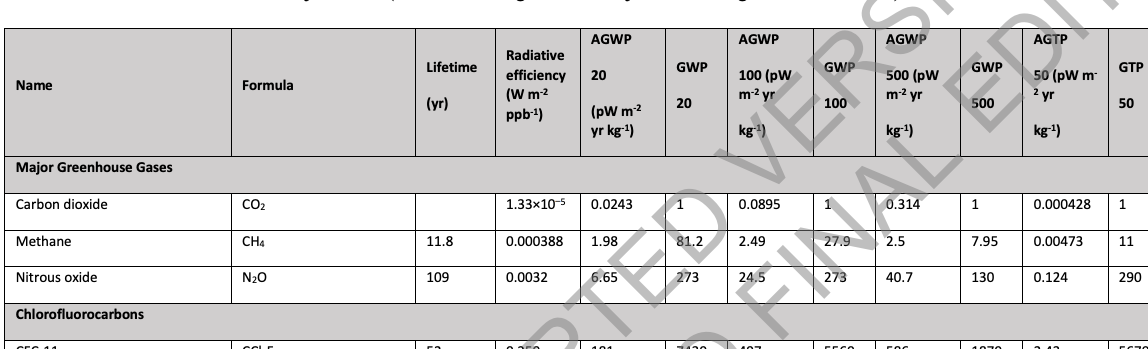

In [ ]:
def get_gas_single_RE_year_ssp(col_ssp, whichgas): 
    
    """
        gas_re_ssp1001: from get_co2_1ppm_erf() / get_ch4_1ppb_erf() with shape (551 (fair1750-2300), 1001)
    """
    gas_re_ssp1001 = []
    y_start = 2000 
    fair_end_y = 2500
    
    # year_index doesn't matter when extracting gas_ppm_diff, it's the output from fair 
    # in ModuleB calc metrics, re = gas_ppm_diff[t], here you get re for year_t (starting year)    
    
    for x in col_ssp: 
        f36 = majorghg_get_f(f = f, H_max=200, ts_per_year = 1, scn = x)  
        if whichgas == "CO2": 
            gas_re = f36.get_co2_1ppm_erf() 
            tt = whichgas+'_RE:W/m2/ppm'
        elif whichgas == "CH4": 
            gas_re = f36.get_ch4_1ppb_erf()
            tt = whichgas+'_RE:W/m2/ppb'
        elif whichgas == "N2O": 
            gas_re =  f36.get_n2o_1ppb_erf() 
            tt = whichgas+'_RE:W/m2/ppb'
        
        gas_re_ssp1001.append(gas_re)
            
    # from above fair 1001 ensmb, get single RE value for each year 
    gas_re_ssp_single = [] 
    for i in range(len(gas_re_ssp1001)):
        single_re = []
        for x in gas_re_ssp1001[i]:
            x_md = np.median(x)
            single_re.append(x_md)
        gas_re_ssp_single.append(single_re)
        
    
    gas_re_df = pd.DataFrame(zip(*gas_re_ssp_single), columns = col_ssp)
    
    
    
    
    
    fig = plt.figure(figsize=(10, 6))
    for column in gas_re_df.columns:
        plt.plot(gas_re_df.index+y_start, gas_re_df[column], label=column)
    plt.xlabel('Year')
    plt.ylabel('RE per unit gas')
    plt.title( tt)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    fig2 = px.line(gas_re_df, x = np.arange(y_start, fair_end_y+1), y=gas_re_df.columns[0:], title = tt)
    fig2.update_yaxes(exponentformat="e")  #https://plotly.com/python/reference/layout/yaxis/#layout-yaxis-autotypenumbers
    fig2.update_layout(
        yaxis_title="RE per unit gas",
        legend_title=whichgas
    )
    #fig.show()
    
    
    return fig, fig2, gas_re_df

In [ ]:
figco2, figco2_html, reco2 = get_gas_single_RE_year_ssp(["ssp119", "ssp245", "ssp585"], "CO2")

In [ ]:
figch4, figch4_html,  rech4 = get_gas_single_RE_year_ssp( ["ssp119", "ssp245", "ssp585"], "CH4")

In [ ]:
fign2o, fign2o_html,  ren2o = get_gas_single_RE_year_ssp( ["ssp119", "ssp245", "ssp585"], "N2O")

#### to get / save HTML 

In [ ]:
from plotly.offline import plot


# Save the figure as an HTML file
plot(figch4_html, filename='CH4_RE_SSPx_StartY2000.html') 
plot(figco2_html, filename='CO2_RE_SSPx_StartY2000.html') 
plot(fign2o_html, filename='CO2_RE_SSPx_StartY2000.html') 
